<a href="https://colab.research.google.com/github/Shivam2Goyal/Network-Intrusion-Detector/blob/main/NID_using_NB_Combined_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from urllib.request import urlretrieve

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.naive_bayes import GaussianNB


In [2]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
print('Datasets have been downloaded.')

Datasets have been downloaded.


In [3]:
# (a) Evluating on 1st dataset- KDD Cup '99

#defining columns (naming each of the 41 features+ the target label vector)
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a

#Therefore, we can see that the KDD Dataset contains lot of redundant(duplicate) data and is highly imbalanced

(494021, 42)
(145586, 42)
{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [4]:
# Preprocessing Data

# Convert categorical columns using Label Encoding
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Convert labels to binary: 0 for normal, 1 for attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

# Extract features and labels
X = df.drop("label", axis=1).values
y = df["label"].values

# Splitting into training, validation and test data set (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data
X_val = scaler.transform(X_val)          # Apply same transformation to validation
X_test = scaler.transform(X_test)        # Apply same transformation to test

In [25]:
def evaluate_model(y_true, y_pred, title=""):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()


In [6]:
class NaiveBayesScratch:
    def __init__(self):
        self.classes = None
        self.class_priors = {}
        self.means = {}
        self.variances = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(y)
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0) + 1e-9

    def _gaussian_pdf(self, x, mean, var):
        exponent = np.exp(-((x - mean)**2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                log_prior = np.log(self.class_priors[c])
                log_likelihood = np.sum(np.log(self._gaussian_pdf(x, self.means[c], self.variances[c])))
                posteriors[c] = log_prior + log_likelihood
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


<ipython-input-6-e8abeb1a2a9c>:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(self._gaussian_pdf(x, self.means[c], self.variances[c])))



--- Custom NB - Train Set ---
Accuracy : 0.9739
Precision: 0.9796
Recall   : 0.9540
F1 Score : 0.9667


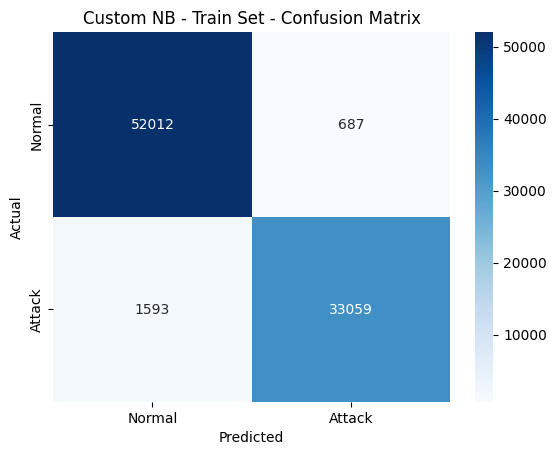


--- Custom NB - Validation Set ---
Accuracy : 0.9760
Precision: 0.9816
Recall   : 0.9574
F1 Score : 0.9694


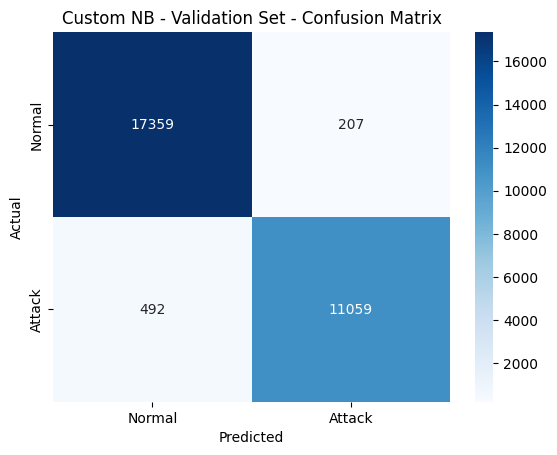


--- Custom NB - Test Set ---
Accuracy : 0.9737
Precision: 0.9781
Recall   : 0.9552
F1 Score : 0.9665


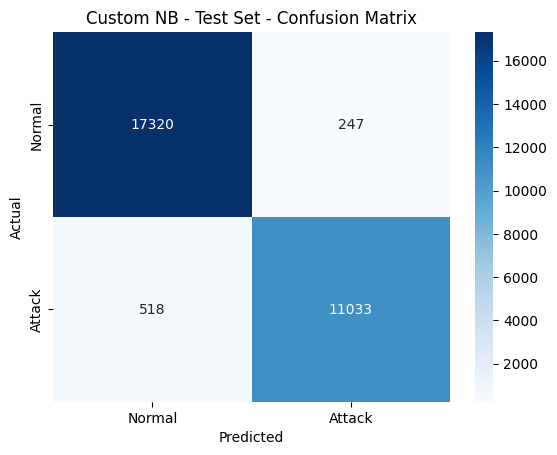

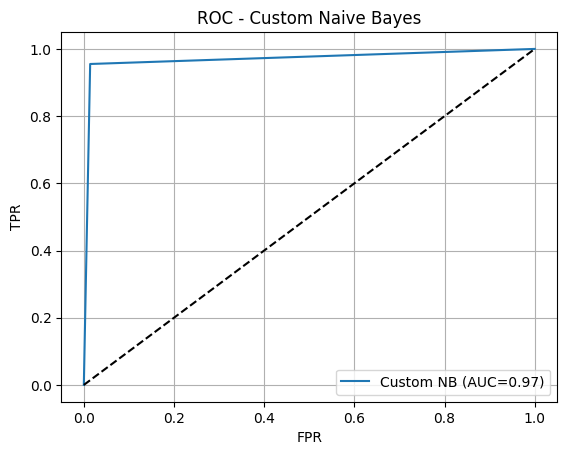

In [7]:
custom_nb = NaiveBayesScratch()
custom_nb.fit(X_train, y_train)

y_train_pred = custom_nb.predict(X_train)
y_val_pred = custom_nb.predict(X_val)
y_test_pred = custom_nb.predict(X_test)

evaluate_model(y_train, y_train_pred, "Custom NB - Train Set")
evaluate_model(y_val, y_val_pred, "Custom NB - Validation Set")
evaluate_model(y_test, y_test_pred, "Custom NB - Test Set")

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, label=f"Custom NB (AUC={auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC - Custom Naive Bayes")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


Best var_smoothing: 0.01
Best F1 Score from CV: 0.9661713616339771


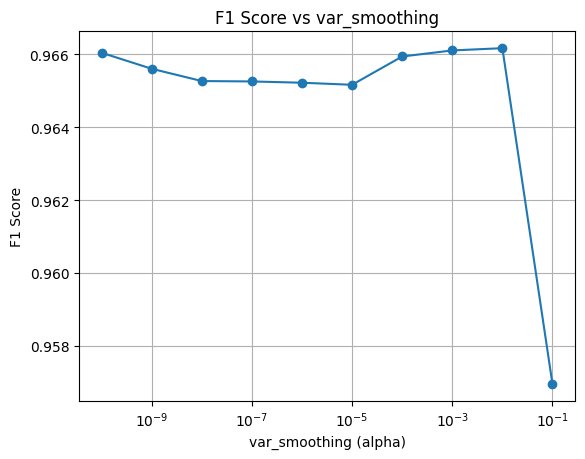


--- GaussianNB - Train Set ---
Accuracy : 0.9736
Precision: 0.9841
Recall   : 0.9487
F1 Score : 0.9661


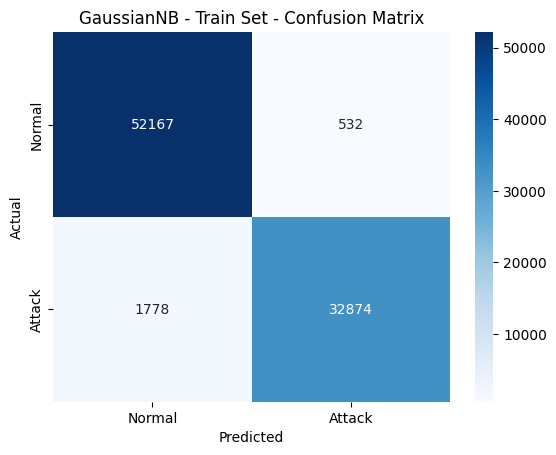


--- GaussianNB - Validation Set ---
Accuracy : 0.9743
Precision: 0.9850
Recall   : 0.9498
F1 Score : 0.9671


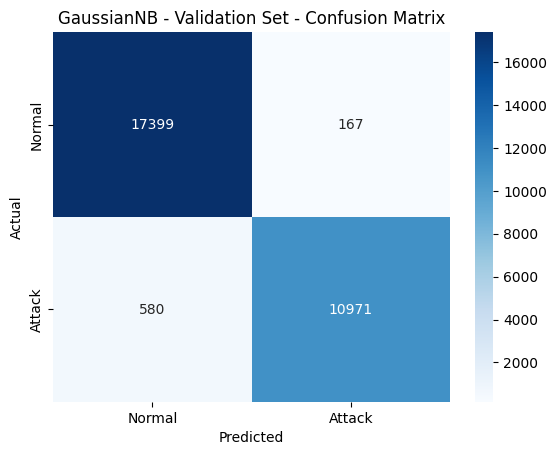


--- GaussianNB - Test Set ---
Accuracy : 0.9739
Precision: 0.9833
Recall   : 0.9504
F1 Score : 0.9665


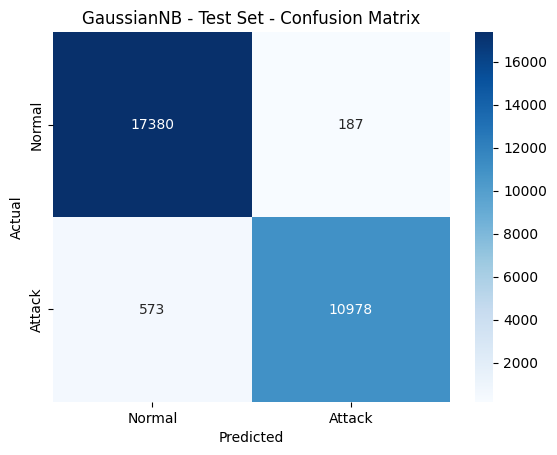

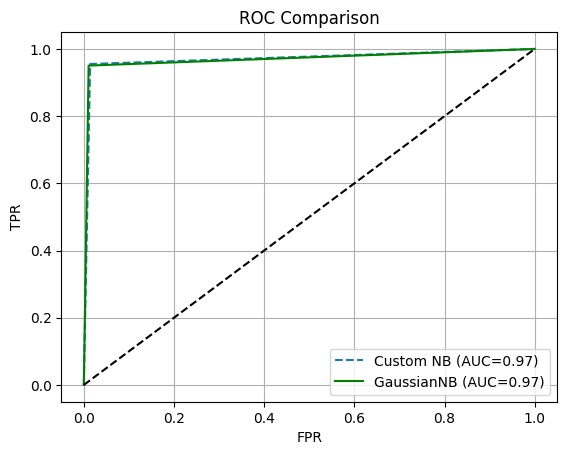

In [8]:
alphas = np.logspace(-10, -1, 10)
param_grid = {'var_smoothing': alphas}
gnb = GaussianNB()
grid = GridSearchCV(gnb, param_grid, scoring='f1', cv=3)
grid.fit(X_train, y_train)

print("Best var_smoothing:", grid.best_params_['var_smoothing'])
print("Best F1 Score from CV:", grid.best_score_)

# Plot F1 vs alpha
scores = grid.cv_results_['mean_test_score']
plt.plot(alphas, scores, marker='o')
plt.xscale("log")
plt.xlabel("var_smoothing (alpha)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs var_smoothing")
plt.grid()
plt.show()

# Evaluate best model
best_gnb = grid.best_estimator_
y_train_pred = best_gnb.predict(X_train)
y_val_pred = best_gnb.predict(X_val)
y_test_pred = best_gnb.predict(X_test)

evaluate_model(y_train, y_train_pred, "GaussianNB - Train Set")
evaluate_model(y_val, y_val_pred, "GaussianNB - Validation Set")
evaluate_model(y_test, y_test_pred, "GaussianNB - Test Set")

# ROC
fpr_g, tpr_g, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, label=f"Custom NB (AUC={auc(fpr, tpr):.2f})", linestyle='--')
plt.plot(fpr_g, tpr_g, label=f"GaussianNB (AUC={auc(fpr_g, tpr_g):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()


In [12]:
# Corrected column names for NSL-KDD (43 columns)
column_names_nsl = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty_level"
]


In [14]:
df_train_nsl = pd.read_csv(train_file, header=None)
df_test_nsl = pd.read_csv(test_file, header=None)

df_train_nsl.columns = column_names_nsl
df_test_nsl.columns = column_names_nsl

# Drop the 'difficulty_level' column (not useful for classification)
df_train_nsl.drop(columns=['difficulty_level'], inplace=True)
df_test_nsl.drop(columns=['difficulty_level'], inplace=True)

# Merge into one combined dataframe
df_nsl = pd.concat([df_train_nsl, df_test_nsl], ignore_index=True)


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Encode label column: binary classification (normal vs attack)
df_nsl['label'] = df_nsl['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Categorical columns to one-hot encode
categorical_cols = ['protocol_type', 'service', 'flag']
df_nsl_encoded = pd.get_dummies(df_nsl, columns=categorical_cols)

# Separate features and label
X_nsl = df_nsl_encoded.drop(columns=['label'])
y_nsl = df_nsl_encoded['label']

# Scale features
scaler = StandardScaler()
X_nsl_scaled = scaler.fit_transform(X_nsl)

# Split into train, validation, and test (70/15/15)
X_train_nsl, X_temp_nsl, y_train_nsl, y_temp_nsl = train_test_split(X_nsl_scaled, y_nsl, test_size=0.3, random_state=42, stratify=y_nsl)
X_val_nsl, X_test_nsl, y_val_nsl, y_test_nsl = train_test_split(X_temp_nsl, y_temp_nsl, test_size=0.5, random_state=42, stratify=y_temp_nsl)

# Confirm the shapes
print(f"Train: {X_train_nsl.shape}, Validation: {X_val_nsl.shape}, Test: {X_test_nsl.shape}")


Train: (103961, 122), Validation: (22278, 122), Test: (22278, 122)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Train Evaluation:
Accuracy : 0.8830522984580756
Precision: 0.979267922235723
Recall   : 0.773328802174956
F1 Score : 0.8641989098382629


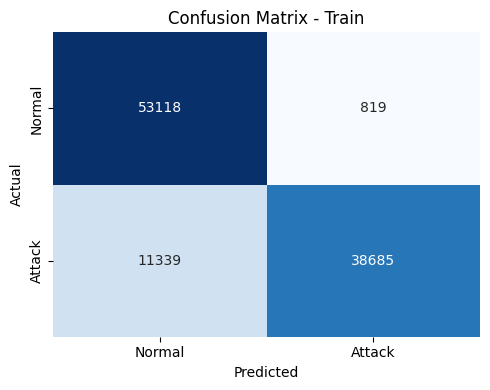


Validation Evaluation:
Accuracy : 0.8797019481102433
Precision: 0.9784575101166388
Recall   : 0.766884328358209
F1 Score : 0.8598472963079176


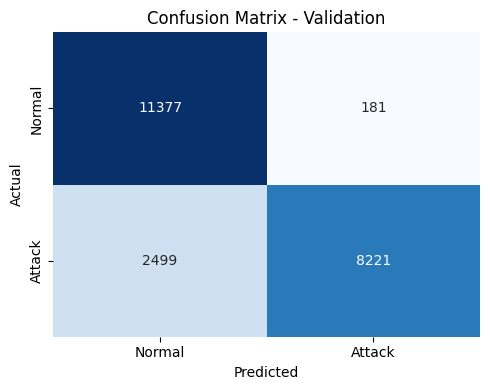


Test Evaluation:
Accuracy : 0.8868839213573929
Precision: 0.9798665574154278
Recall   : 0.7809497154585315
F1 Score : 0.8691724639185961


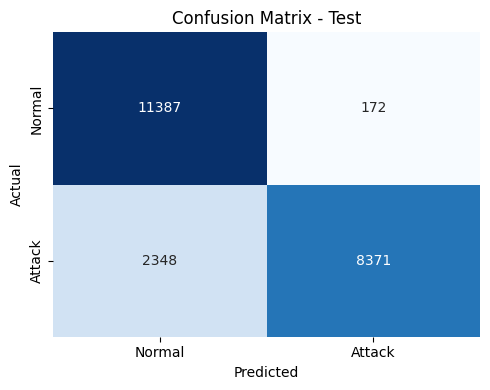

In [21]:
# Train GaussianNB with hyperparameter tuning
param_grid = {'var_smoothing': np.logspace(-9, -1, 10)}
grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='f1', verbose=1)
grid.fit(X_train_nsl, y_train_nsl)

best_nb = grid.best_estimator_

# Predict on train, val, and test sets
y_train_pred = best_nb.predict(X_train_nsl)
y_val_pred = best_nb.predict(X_val_nsl)
y_test_pred = best_nb.predict(X_test_nsl)

# Evaluation metrics
def evaluate(y_true, y_pred, dataset_name=""):
    print(f"\n{dataset_name} Evaluation:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

# Visual confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Evaluate and plot
evaluate(y_train_nsl, y_train_pred, "Train")
plot_confusion_matrix(y_train_nsl, y_train_pred, title="Confusion Matrix - Train")

evaluate(y_val_nsl, y_val_pred, "Validation")
plot_confusion_matrix(y_val_nsl, y_val_pred, title="Confusion Matrix - Validation")

evaluate(y_test_nsl, y_test_pred, "Test")
plot_confusion_matrix(y_test_nsl, y_test_pred, title="Confusion Matrix - Test")

In [31]:
# Fit custom Naive Bayes
custom_nb = NaiveBayesScratch()
custom_nb.fit(X_train_nsl, y_train_nsl)

# Predict with custom Naive Bayes
y_train_pred_custom_nsl = custom_nb.predict(X_train_nsl)
y_val_pred_custom_nsl = custom_nb.predict(X_val_nsl)
y_test_pred_custom_nsl = custom_nb.predict(X_test_nsl)

<ipython-input-6-e8abeb1a2a9c>:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(self._gaussian_pdf(x, self.means[c], self.variances[c])))



NSL-KDD Train (Custom NB) Evaluation:
Accuracy : 0.8093708217504642
Precision: 0.995700406984377
Recall   : 0.6064489045258276
F1 Score : 0.7537891964418825


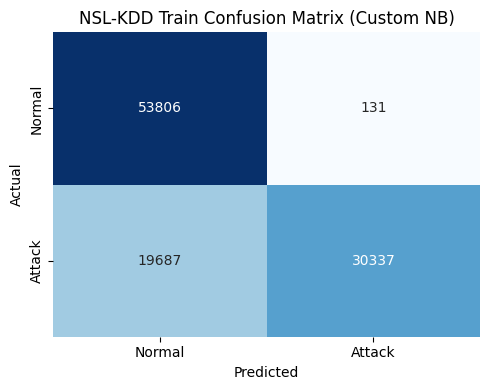


NSL-KDD Validation (Custom NB) Evaluation:
Accuracy : 0.8046503276775294
Precision: 0.9937965260545906
Recall   : 0.5977611940298507
F1 Score : 0.7465051258154707


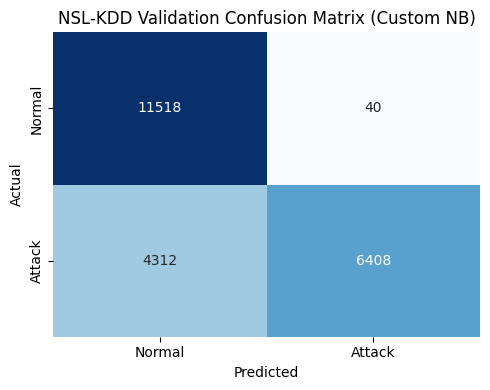


NSL-KDD Test (Custom NB) Evaluation:
Accuracy : 0.8112936529311429
Precision: 0.9951360389116887
Recall   : 0.6107845881145629
F1 Score : 0.7569661232512429


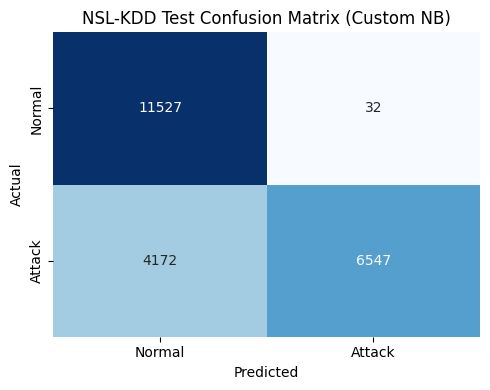

In [32]:
evaluate(y_train_nsl, y_train_pred_custom_nsl, "NSL-KDD Train (Custom NB)")
plot_confusion_matrix(y_train_nsl, y_train_pred_custom_nsl, title="NSL-KDD Train Confusion Matrix (Custom NB)")

evaluate(y_val_nsl, y_val_pred_custom_nsl, "NSL-KDD Validation (Custom NB)")
plot_confusion_matrix(y_val_nsl, y_val_pred_custom_nsl, title="NSL-KDD Validation Confusion Matrix (Custom NB)")

evaluate(y_test_nsl, y_test_pred_custom_nsl, "NSL-KDD Test (Custom NB)")
plot_confusion_matrix(y_test_nsl, y_test_pred_custom_nsl, title="NSL-KDD Test Confusion Matrix (Custom NB)")


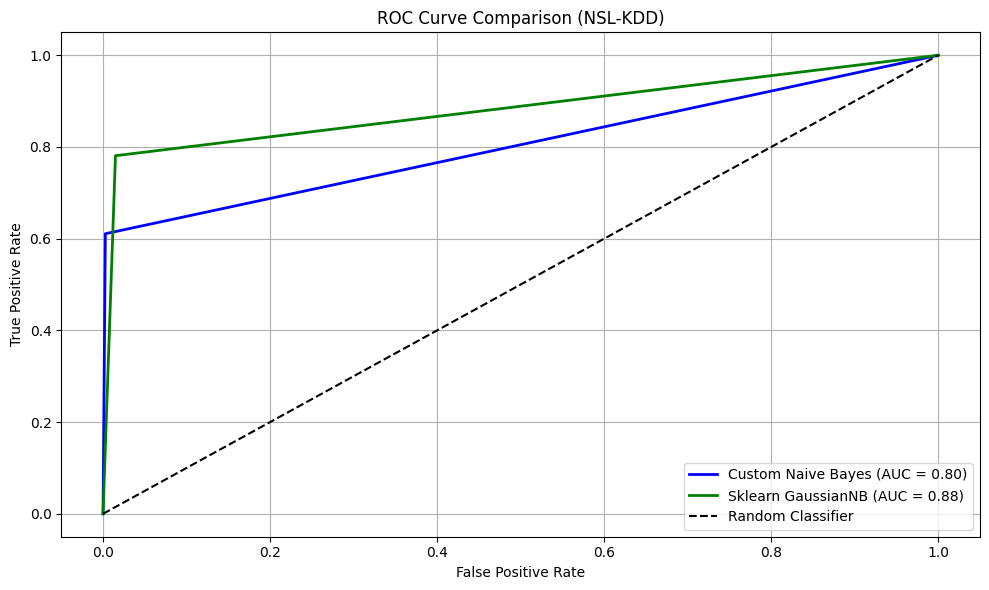

In [34]:
# ROC curve for Custom Naive Bayes on NSL-KDD
fpr_custom_nsl, tpr_custom_nsl, _ = roc_curve(y_test_nsl, y_test_pred_custom_nsl)
roc_auc_custom_nsl = auc(fpr_custom_nsl, tpr_custom_nsl)

# ROC curve for Sklearn GaussianNB on NSL-KDD
# Use y_test_pred which was generated using the held-out test set
# fpr_sklearn_nsl, tpr_sklearn_nsl, _ = roc_curve(y_test_nsl, y_test_pred)
fpr_sklearn_nsl, tpr_sklearn_nsl, _ = roc_curve(y_test_nsl, best_nb.predict(X_test_nsl))
roc_auc_sklearn_nsl = auc(fpr_sklearn_nsl, tpr_sklearn_nsl)

# Plot ROC curve comparison for NSL-KDD
plt.figure(figsize=(10, 6))
plt.plot(fpr_custom_nsl, tpr_custom_nsl, color='blue', lw=2, label=f'Custom Naive Bayes (AUC = {roc_auc_custom_nsl:.2f})')
plt.plot(fpr_sklearn_nsl, tpr_sklearn_nsl, color='green', lw=2, label=f'Sklearn GaussianNB (AUC = {roc_auc_sklearn_nsl:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (NSL-KDD)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()